# Template for Practical work on the Conversion of sampling frequency and STFT


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2020*

**python version : 3.6**

In [1]:
import os, sys, wave, struct

import gc
import numpy as np
import pyaudio
#import pandas as pd
import matplotlib.pyplot as plt
import scipy
from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write

## Functions

In [16]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [17]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [18]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


In [29]:
play = True
if play :
    play_sound(sound) 

In [19]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [20]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

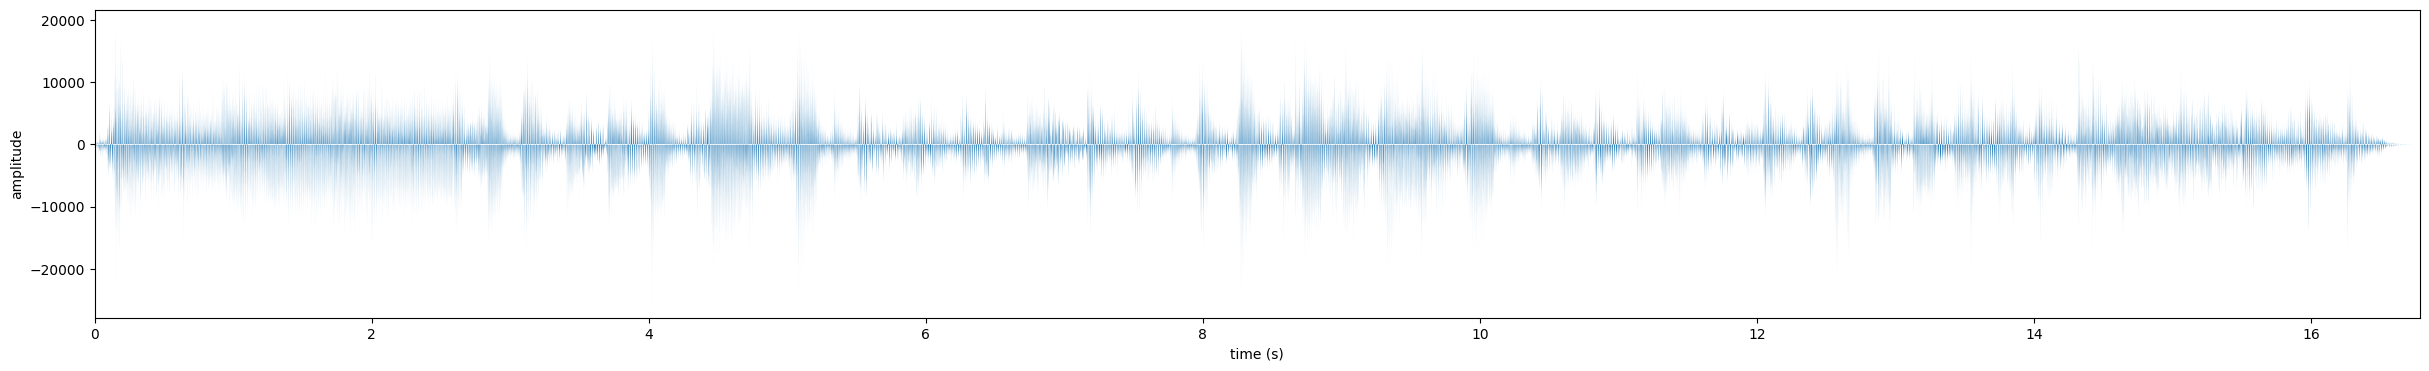

In [21]:
plot_sound(x, times)

In [30]:
write('new_caravan.wav', Fs, np.array(x, dtype=np.int16)) # to write a new wave file

## Signal analysis with the STFT

In [22]:
N = x.shape[0] # % longueur du signal
Nw = 512
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = w.copy; # définition de la fenêtre de synthèse
R = Nw/4 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 512 # ordre de la tfd
L = M//2+1
affich = 1 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

In [23]:
for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # début de trame
    fin = deb + Nw # fin de trame
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # calcul de la trame 
    X = np.fft.fft(tx,M) # tfd à l'instant b
    if affich:
        Xtilde[:,u] = X
    # opérations de transformation (sur la partie \nu > 0)
    # ....
    Y = X.copy
    # fin des opérations de transformation
    # resynthèse
    # overlap add

def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]

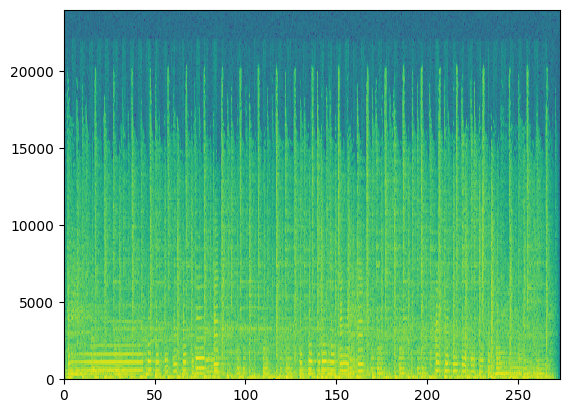

In [31]:
if affich:
    plt.imshow(20*np.log10(np.abs(Xtilde[np.arange(0,L),:])), aspect='auto',interpolation='none',
               origin='lower', extent=[0, Nt * R / Fs + Nw / 2, 0, Fs/2])

## Overlap-add reconstruction

In [24]:
def ola(w = None,hop = None,Nb = 10): 
# function output = ola(w,hop,Nb)
# realise l'addition-recouvrement de la fenetre w,
# avec un décalage hop et un nombre Nb de fenetres.
# par defaut Nb = 10;
    
    w = w[:, np.newaxis]
    N = len(w)
    output = np.zeros(((Nb - 1) * hop + N,1)) # réserve l'espace memoire
    
    for k in np.arange(0,Nb).reshape(-1):
        deb = k* hop
        fin = deb + N
        output[np.arange(deb,fin)] = output[np.arange(deb,fin)] + w # OLA
    
    return output

## I-Conversion of sampling rate

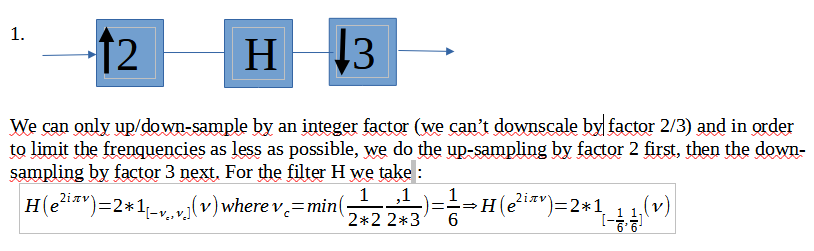

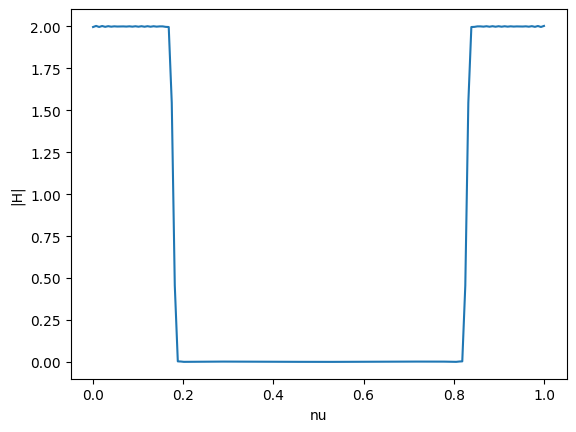

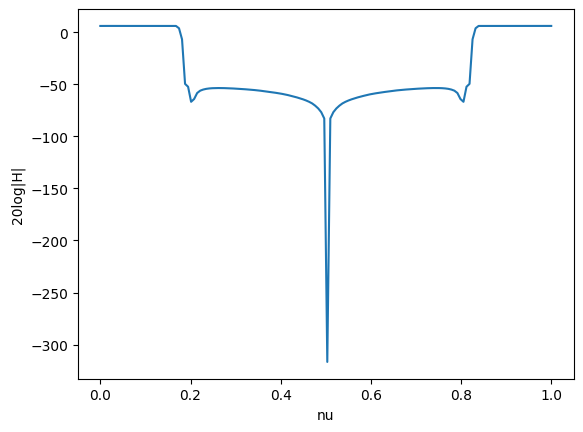

In [37]:
#Q2
l=150
h = scipy.signal.remez(l, [0,1/6,1/6+1/50,0.5],[2,0])
hf = np.fft.fft(h)
f = np.linspace(0,1,l)
plt.plot(f,abs(hf))
plt.xlabel('nu')
plt.ylabel('|H|')
plt.show()
plt.plot(f,20*np.log10(abs(hf)))
plt.xlabel('nu')
plt.ylabel('20log|H|') # We observe a difference higher than 50dB between the pass-band and the stop-band, our synthesis is correct
plt.show()

#Q3 resamples by 2/3 factor
def downsample(x,M):
    y=[]
    for i in range(len(x)):
        if i%M == 0:
            y.append(x[i])
    return y

def upsample(x,L):
    y=[]
    for i in range(L*len(x)-(L-1)):
        if i%L == 0:
            y.append(x[i//L])
        else:
            y.append(0)
    return y

def resample(x,M,L):
    y = upsample(x,L)
    y = scipy.signal.lfilter(h,[1],y)
    y = downsample(y,M)
    return y

x_resampled = resample(x,3,2)
write('caravan_32khz.wav', 32000, np.array(x_resampled, dtype=np.int16))
sound1 = os.path.join(data_path, 'caravan_32khz.wav')
play_sound(sound1)


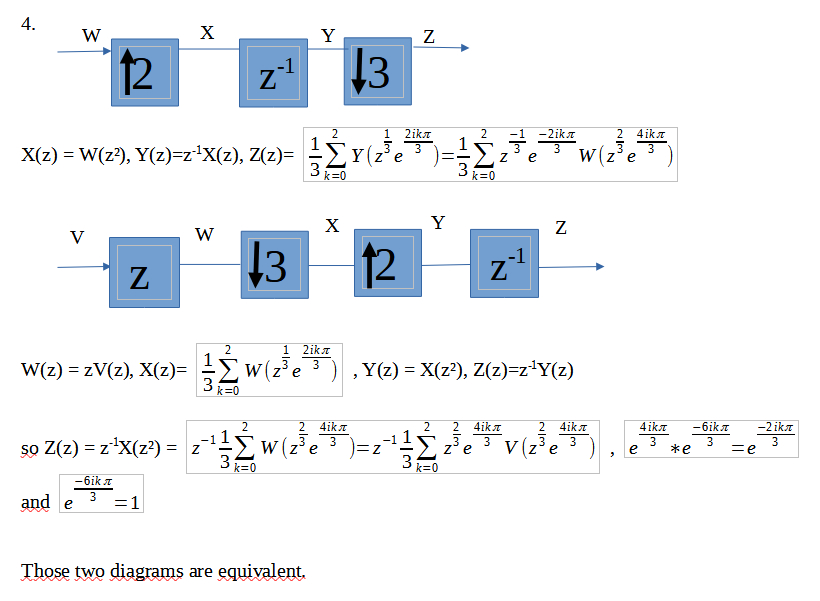

In [41]:
#Q5
R0,R1,E00, E10, E20, E01, E11, E21 =[],[],[],[],[],[],[],[]

#definition of polyphase components
for i in range(l):
    if i%2 == 0:
        R0.append(h[i])
    else:
        R1.append(h[i])

for j in range(len(R0)):
    if j%3 == 0:
        E00.append(R0[j])
    elif j%3 == 1:
        E10.append(R0[j])
    else:
        E20.append(R0[j])

for k in range(len(R1)):
    if k%3 == 0:
        E01.append(R1[j])
    elif k%3 == 1:
        E11.append(R1[j])
    else:
        E21.append(R1[j])

#separation of x for indices of the form 3n,3n+1 and 3n+2; a,b and c all have the same size to allow zip() to work in the next function
def split3(x):
    if len(x)%3 == 0:
        a = [x[i] for i in range(0,len(x),3)]
        b = [x[i] for i in range(1,len(x),3)]
        c = [x[i] for i in range(2,len(x),3)]
    else:
        l3 = len(x)//3+1
        a,b,c = [0 for _ in range(l3)],[0 for _ in range(l3)],[0 for _ in range(l3)]
        for i in range(len(x)):
            if i%3 == 0:
                a[i//3] = x[i] 
            if i%3 == 1:
                b[i//3] = x[i]
            if i%3 == 2:
                c[i//3] = x[i]
    return a,b,c

#resampling by 2/3 factor
def efficient_resample(x):
    a,b,c = split3(x)
    y0=scipy.signal.lfilter(E00,[1],a)
    y1=scipy.signal.lfilter(E10,[1],b)
    y2=scipy.signal.lfilter(E20,[1],c)
    z0=scipy.signal.lfilter(E01,[1],a)
    z1=scipy.signal.lfilter(E11,[1],b)
    z2=scipy.signal.lfilter(E21,[1],c)
    y = [sum(x) for x in zip(y0,y1,y2)]
    z = [sum(x) for x in zip(z0,z1,z2)]
    r=[]
    for i in range(2*len(y)):
        if i%2 == 0:
            r.append(y[i//2])
        else:
            r.append(z[i//2])
    return r

#Q6
original, ver2 = False, True

x2 = efficient_resample(x)
write('caravan_32khz_efficient.wav', 32000, np.array(x2, dtype=np.int16))

sound2 = os.path.join(data_path, 'caravan_32khz_efficient.wav')

if original:
    play_sound(sound)
if ver2:
    play_sound(sound2)



25
25
25
25
25
25


## II-STFT audio equalization

C:\Users\maelm\AppData\Local\Temp\ipykernel_17828\30192289.py:7: RuntimeWarning: divide by zero encountered in log10
  Wshift = 20*np.log10(abs(np.fft.fftshift(W)))


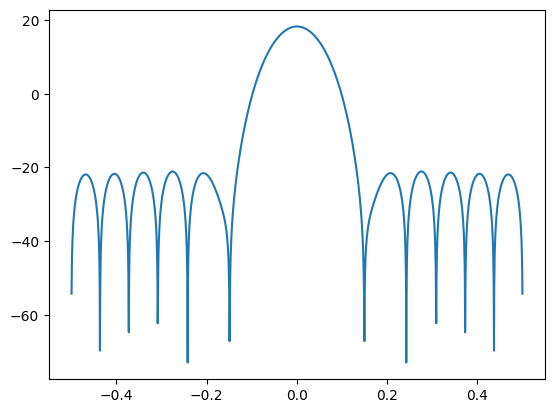

In [81]:
#Q1
Nw1=16
w1 = np.hamming(Nw1)
M1=2048
W = np.fft.fft(w1,M1)
x = np.linspace(-0.5,0.5,len(W))
Wshift = 20*np.log10(abs(np.fft.fftshift(W)))
plt.plot(x,Wshift) # The width of the first lobe is 2/Nw

Q2: The STFT can be written as the convolution product of $(x_{n}e^{-2i\pi\lambda n})_n$ and $(w_{-n})_n$\
This means the STFT of X can be viewed as a filtering of $(x_{n}e^{-2i\pi\lambda n})_n$ by $(w_{-n})_n$ which is a low pass filter.\
The frequency response is symettric so the filter is either of type I or II depending on whether its length is even or odd.\
\
Q3: This new convention can be seen as the convolution between $(x_n)_n$ and $(w_ne^{-2i\pi\lambda n})_n$ which corresponds to the filtering of x by the hann window centered around b instead of 0, which makes it a band-pass, hence the name of this convention. \
$\~X(\lambda,b) = e^{2i\pi\lambda b}W_x(\lambda,b)$\
The convention used in the notebook above is the band-pass one because we pick values of x starting from the ${N_w/4}^{th}$ value.\
\
Q4: $x_3(u)$ is complex as shown by the print below.

In [42]:
#Q4
print(Xtilde[2,:])
play_stft = True

if play_stft:
    write('caravan_STFT.wav', 32000, np.array(np.real(Xtilde[2,:]), dtype=np.int16))
    sound3 = os.path.join(data_path, 'caravan_STFT.wav')
    play_sound(sound3)

[ 6.60481429e+03-3.24065537e+03j -6.89056977e+03+6.32304995e+03j
  2.95793816e+03-1.67842374e+04j ... -1.06350752e+01+1.11152659e+01j
  1.09991893e+01-2.70938763e+00j -5.84191392e+00-1.71483042e+00j]


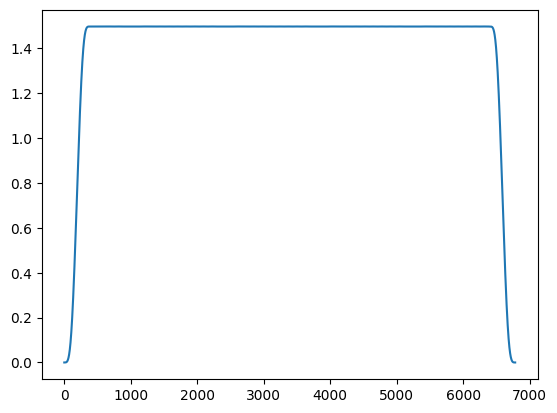

In [43]:
#Q5
h = np.multiply(w,w)
f = ola(h,int(1/4*Nw),50)
plt.plot(f)
plt.show()

This is a finite sum so it is not a constant function and in order to have a value of 1 pretty much everywhere, except on the edges, we divide both w by the square root of the maximum of the function above

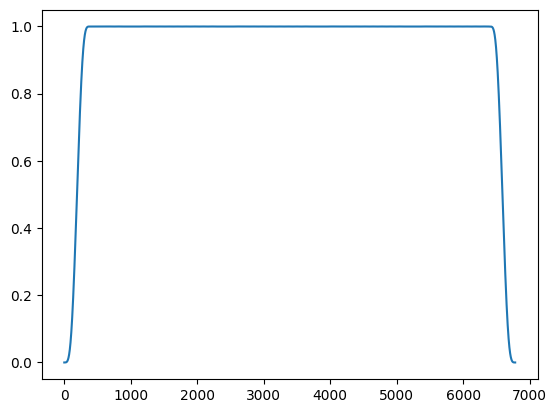

In [84]:
h = np.multiply(w/np.sqrt(max(f)),w/np.sqrt(max(f)))
f = ola(h,int(1/4*Nw),50)
plt.plot(f)
plt.show()

C:\Users\maelm\AppData\Local\Temp\ipykernel_17828\2599261032.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  y[b:h]= y[b:h]+np.multiply(idft,w/np.sqrt(max(f)))


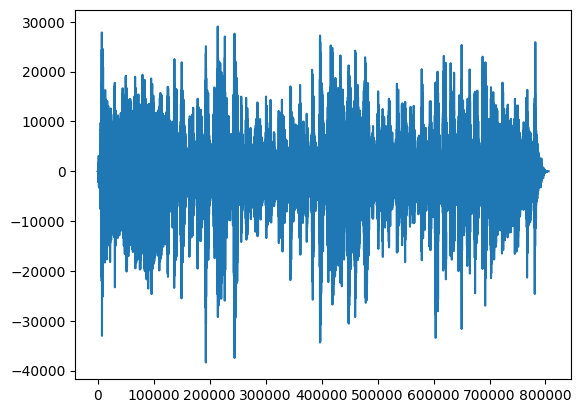

In [129]:
#Q6
def stft_reconstruct(Xtilde):
    y= np.zeros(N)
    for u in range(Nt):
        b = int(u*R)
        h = int(b + Nw)
        idft = np.fft.ifft(Xtilde[:,u],M)
        y[b:h]= y[b:h]+np.multiply(idft,w/np.sqrt(max(f)))
    return y


y = stft_reconstruct(Xtilde)
plt.plot(y)
plt.show()
write('caravan_reconstruct.wav', 48000, np.array(y, dtype=np.int16))
sound4 = os.path.join(data_path, 'caravan_reconstruct.wav')
play_sound(sound4)

C:\Users\maelm\AppData\Local\Temp\ipykernel_17828\2599261032.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  y[b:h]= y[b:h]+np.multiply(idft,w/np.sqrt(max(f)))


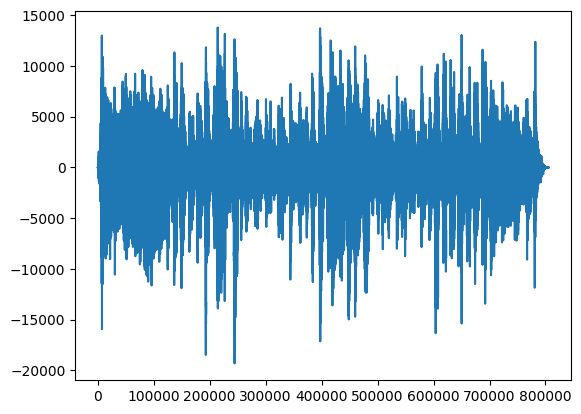

In [133]:
#Q7
order = M//2+1

def weighting(x,w):
    y = x.copy()
    for k in range(len(w)):
        y[k,:] = w[k]*y[k,:]
    return y

weights = 0*np.ones(order)
Ytilde = weighting(Xtilde,weights)
y = stft_reconstruct(Ytilde)

plt.plot(y)
plt.show()

write('caravan_reconstruct_equalize.wav', 48000, np.array(y, dtype=np.int16))
sound5 = os.path.join(data_path, 'caravan_reconstruct_equalize.wav')
play_sound(sound5)